#  <font><b>💎 Image Segmentation/ Dataset 💎</b></font>


# **Import Libraries**

In [1]:
!rm -rf /content/sample_data

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from tqdm import tqdm
import os
import random

#  **Download & Unzip the Dataset**

In [3]:
!mkdir dataset

In [ ]:
!unzip /content/drive/MyDrive/3_Howsam_Image_Segmentation/uw-madison-gi-tract-image-segmentation.zip -d /content/dataset

#  **Len Of different parts of dataset**

In [5]:
dataset_folder = os.listdir('/content/dataset/train')
print('Total number of cases: ', len(dataset_folder), '\n')
value_counts = {}
scan_count = {}

for c in dataset_folder:
  cpath = os.path.join('/content/dataset/train', c)
  cdir = os.listdir(cpath)
  if len(cdir) in value_counts:
      value_counts[len(cdir)] += 1
  else:
      value_counts[len(cdir)] = 1
  for cd in cdir:
    cddir = os.path.join(cpath, cd, 'scans')
    cdlen = len(os.listdir(cddir))
    if cdlen in scan_count:
      scan_count[cdlen] += 1
    else:
      scan_count[cdlen] = 1

print('*'*35)
for k, v in dict(sorted(value_counts.items())).items():
    print(f'Number of cases with {k} days: {v}')

print()
print('*'*35)
sum = 0
for k, v in dict(sorted(scan_count.items())).items():
    print(f'Number of case_day with {k} slices: {v}')
    sum += k*v
print(f'All slices = ', sum)

Total number of cases:  85 

***********************************
Number of cases with 1 days: 9
Number of cases with 2 days: 8
Number of cases with 3 days: 45
Number of cases with 4 days: 2
Number of cases with 5 days: 20
Number of cases with 6 days: 1

***********************************
Number of case_day with 80 slices: 15
Number of case_day with 144 slices: 259
All slices =  38496


#  **Show some random original images**

In [6]:
def show_imgs(index, image_dir):

  image_directory = image_dir
  image_files = os.listdir(image_directory)
  selected_files = random.sample(image_files, index)
  plt.figure(figsize=(8, 8))

  for i, filename in enumerate(selected_files):
      if filename.endswith('.png'):
          parts = filename.split('_')

          slice_width = int(parts[1])
          slice_height = int(parts[2])
          width_pixel_spacing = float(parts[3])
          height_pixel_spacing = float(parts[4])

          image_path = os.path.join(image_directory, filename)
          image = Image.open(image_path)
          plt.subplot(index//3+1,3,i+1)
          plt.imshow(image, cmap='gray', vmin=0, vmax=65535)  #  16-bit depth
          # plt.imshow(image)
          plt.axis('off')

          title = f"Slice Width: {slice_width}px, Slice Height: {slice_height}px\n"
          title += f"Pixel Spacing: {width_pixel_spacing}mm x {height_pixel_spacing}mm\n"
          title += f"Physical Pixel Thickness (S-I direction): 3mm"
          plt.title(title, fontsize = 8)

  plt.tight_layout()
  plt.show()

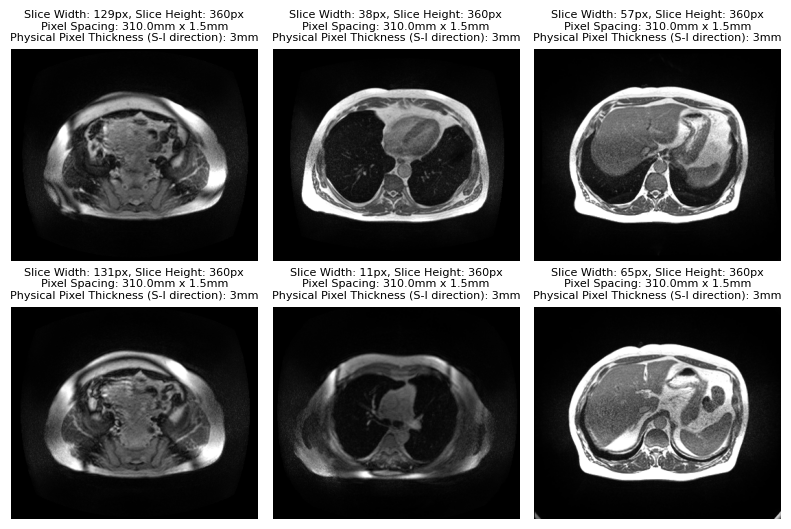

In [7]:
image_directory = "/content/dataset/train/case110/case110_day16/scans"
show_imgs(6, image_directory)

#  **explore train.csv file**

In [8]:
df_train = pd.read_csv('/content/dataset/train.csv')

In [9]:
df_train.describe()

,id,class,segmentation
count,115488,115488,33913
unique,38496,3,33899
top,case123_day20_slice_0001,large_bowel,12629 10 12894 12 13158 15 13423 17 13688 19 1...
freq,3,38496,2


In [10]:
print('All classes of dataset: ', df_train['class'].unique())

All classes of dataset:  ['large_bowel' 'small_bowel' 'stomach']


In [11]:
df_train.head(5)

,id,class,segmentation
0,case123_day20_slice_0001,large_bowel,NaN
1,case123_day20_slice_0001,small_bowel,NaN
2,case123_day20_slice_0001,stomach,NaN
3,case123_day20_slice_0002,large_bowel,NaN
4,case123_day20_slice_0002,small_bowel,NaN


##  **Check if all scans' slices are in csv ids**

In [12]:
ids = df_train['id'].unique()

In [13]:
len(df_train['id']), len(ids)

(115488, 38496)

As we calculated before there are "15 case_day with 80 slices" and "259 case_day with 144 slices". So in total we have "15*80  + 259*144 = 38,496"

And its equal to 38,496 unique slice id in csv.

So all scans' slices are in csv ✅


##  **Check if all ids have 3 row in csv**

In [ ]:
for i in tqdm(ids):
  casecheck = list(df_train['id'] == i).count(True)
  if casecheck != 3:
    print(f"{i} doesn't have 3 row")

100%|██████████| 38496/38496 [17:59<00:00, 35.65it/s]


So all ids correctly have 3 row.

#  **NEW CSV: Add image_path, height and width coulmn to train.csv**

In [14]:
df_pathcol = []
df_hcol = []
df_wcol = []

for id in tqdm(df_train['id']):
  id_split = id.split('_')
  path = os.path.join('/content/dataset/train', id_split[0], id_split[0] + '_' + id_split[1], 'scans')

  matching_files = [f for f in os.listdir(path) if f.startswith(id_split[-2] + '_' + id_split[-1])]

  path2 = os.path.join(path, matching_files[0])

  id_split2 = matching_files[0].split('_')
  height_img = id_split2[2]
  width_img = id_split2[3]

  df_pathcol.append(path2)
  df_hcol.append(height_img)
  df_wcol.append(width_img)

100%|██████████| 115488/115488 [00:19<00:00, 6027.42it/s]


In [15]:
df_train['img_path'] = df_pathcol
df_train['height'] = df_hcol
df_train['width'] = df_wcol

In [16]:
df_train.head(5)

,id,class,segmentation,img_path,height,width
0,case123_day20_slice_0001,large_bowel,NaN,/content/dataset/train/case123/case123_day20/s...,266,266
1,case123_day20_slice_0001,small_bowel,NaN,/content/dataset/train/case123/case123_day20/s...,266,266
2,case123_day20_slice_0001,stomach,NaN,/content/dataset/train/case123/case123_day20/s...,266,266
3,case123_day20_slice_0002,large_bowel,NaN,/content/dataset/train/case123/case123_day20/s...,266,266
4,case123_day20_slice_0002,small_bowel,NaN,/content/dataset/train/case123/case123_day20/s...,266,266


In [17]:
# save new csv
df_train.to_csv('/content/dataset/train_new.csv', index = False)

In [18]:
!cp /content/dataset/train_new.csv /content/drive/MyDrive/3_Howsam_Image_Segmentation

#   **Plot histogram of the number of classes that are not NaN**


In [19]:
df_train[~df_train.segmentation.isna()]['class'].value_counts()

large_bowel    14085
small_bowel    11201
stomach         8627
Name: class, dtype: int64

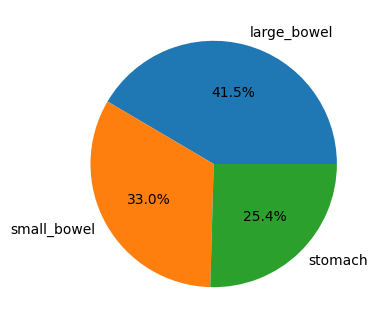

In [20]:
plt.figure(figsize=(4,4))

y = [df_train[~df_train.segmentation.isna()]['class'].value_counts()[0],
     df_train[~df_train.segmentation.isna()]['class'].value_counts()[1],
     df_train[~df_train.segmentation.isna()]['class'].value_counts()[2]]
mylabels = ["large_bowel", "small_bowel", "stomach"]

# fig, ax = plt.subplots()
plt.pie(y, labels=mylabels, autopct='%1.1f%%')
plt.show()

#  **Show some random images with segmentation**

In image segmentation, an RLE mask is a way to represent binary masks in a compact format.

The numbers represent pairs of values, where the first number in each pair is the starting position of a run of "1" values, and the second number is the length of that run.


This is typically used for representing binary segmentation masks where "1" represents the foreground (object of interest) and "0" represents the background.

In [21]:
!cp /content/drive/MyDrive/3_Howsam_Image_Segmentation/ImgSeg_DataUtils.py /content

In [22]:
from ImgSeg_DataUtils import load_img, rle_decode, id2mask, show_img

In [23]:
print('Number of row with NaN in segmentation coloumn: ', len(df_train[df_train.segmentation.isna()]))
print('Number of row with data in segmentation coloumn: ', len(df_train[~df_train.segmentation.isna()]))

Number of row with NaN in segmentation coloumn:  81575
Number of row with data in segmentation coloumn:  33913


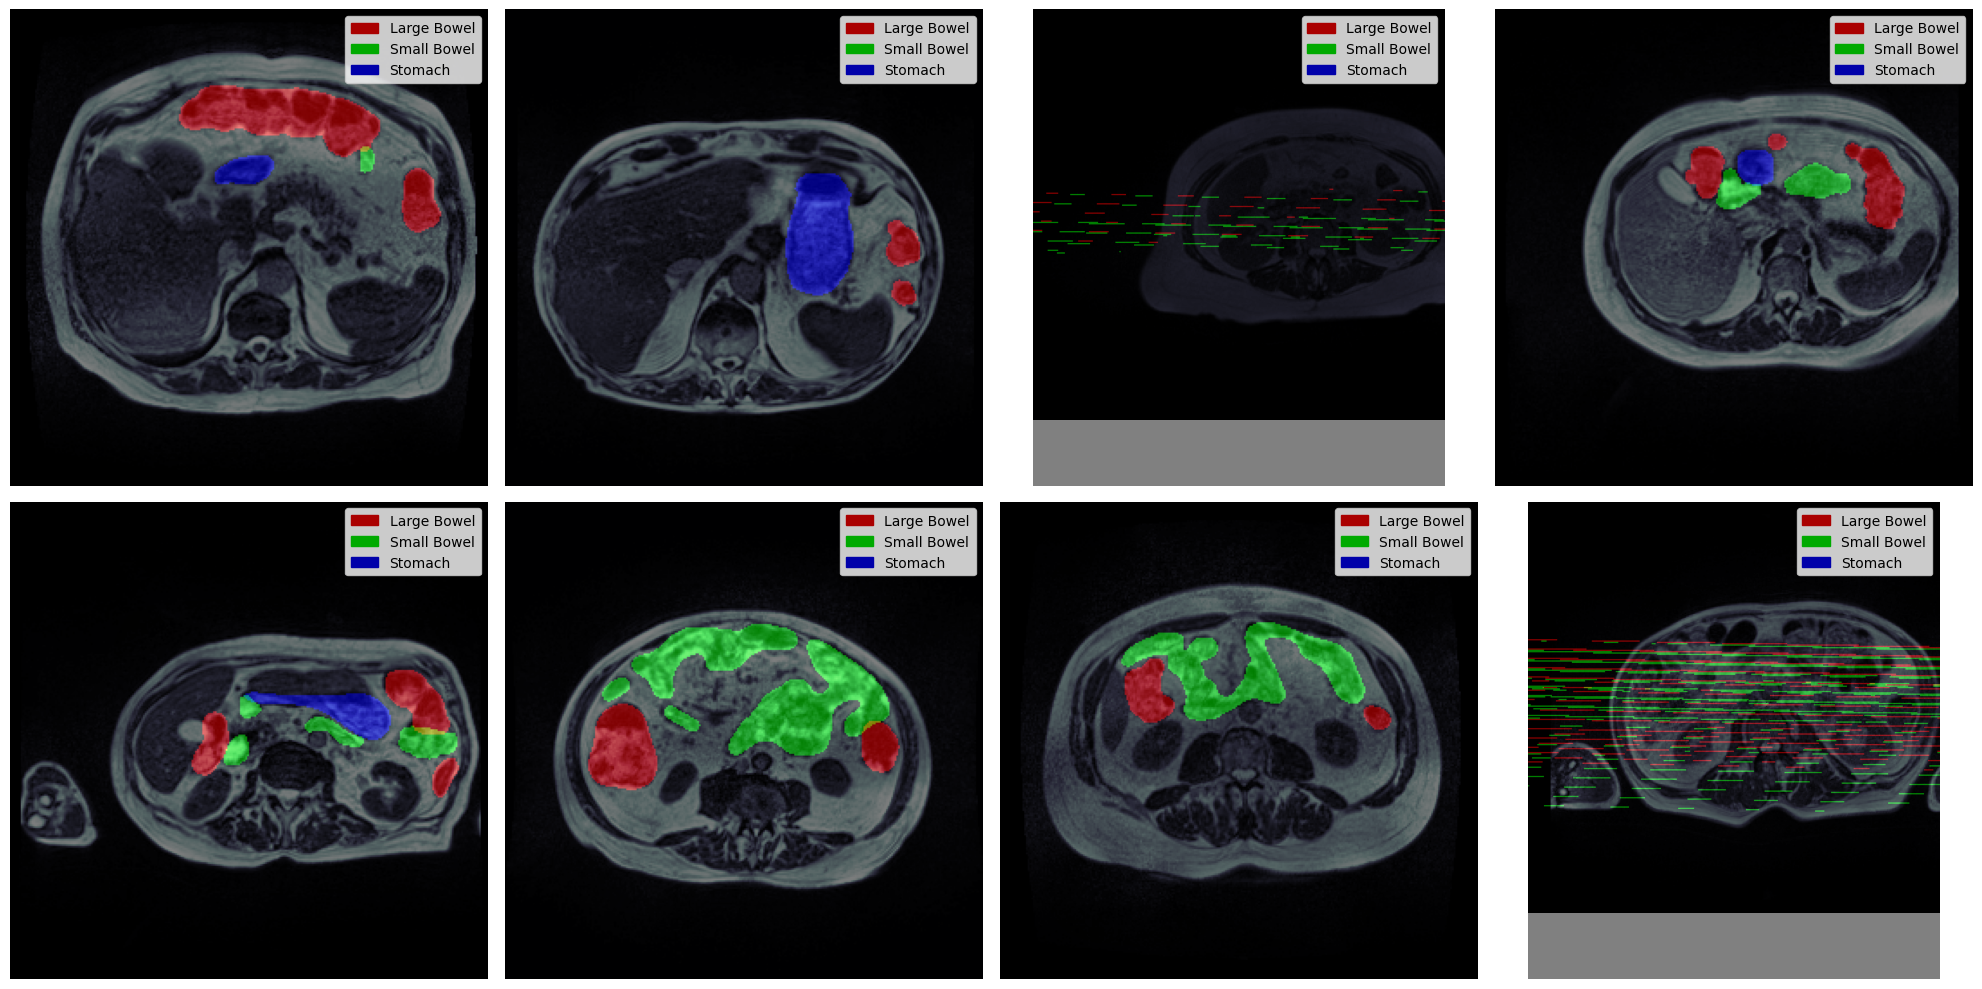

In [24]:
row=2; col=4
plt.figure(figsize=(5*col,5*row))
for i, id_ in enumerate(df_train[~df_train.segmentation.isna()].sample(frac=1.0)['id'].unique()[:row*col]):
    idf_train = df_train[df_train['id']==id_]
    img = load_img(idf_train.img_path.iloc[0])
    mask = id2mask(idf_train)*255  #mask.shape = (266, 266, 3), 3 because of 3 classes, combine 3 class to show in image
    plt.subplot(row, col, i+1)
    i+=1
    show_img(img, mask=mask);
    plt.tight_layout()